# The Tensorflow Way

How to put together objects using eager to dynamically setup the computational graph. Eventually create a classifier.

## Outcomes

* Operations using eager execution
* Layering nested operations
* Working with multiple layers
* Implementing loss functions
* Implementing backpropagation
* Working with batch and stochastic training
* Combining components together

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 14/10/2024   | Martin | Created   | Started chapter 2 | 
| 26/11/2024   | Martin | Updated   | Back at it! Loss functions and Backpropogation | 
| 5/12/2024   | Martin | Updated   | Completed batch and stochastic training data | 

# Content

* [Operations using eager execution](#header-1)
* [Layering Nested Operations](#layering-nested-operations)
* [Working with Multiple Layers](#working-with-multiple-layers)
* [Implementing Loss Functions](#implementing-loss-functions)
* [Implementing Backpropogation](#implementing-backpropogation)
* [Working with Batch and Stochastic Training](#working-with-batch-and-stochastic-training)
* [Combining Everything Together](#combining-everything-together)

# Operations using eager execution

Operating on matrices using eager execution. 

Eager excution allows you to perform operations directly on the results, instead of working on symbolic handles of a computational graph.

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

import tensorflow as tf
import numpy as np

In [4]:
# Convert a numpy array into a tensor and perform an operation
x_vals = np.array([1., 3., 5., 7., 9.])
x_data = tf.Variable(x_vals, dtype=tf.float32)
x_const = tf.constant(3.)

operation = tf.multiply(x_data, x_const)
for val in operation: # where eager execution happens
  print(val.numpy())

3.0
9.0
15.0
21.0
27.0


---

# Layering nested operations

Putting multiple operations together. Multiply 2 matrics then perform addition, each matrix is 3D.

Use common constructs like functions and classes to improve readability and code modularity.

In [5]:
# Starting matrix
array = np.array([[1., 3., 5., 7., 9.],
                  [-2., 0., 2., 4., 6.],
                  [-6., -3., 0., 3., 6.]]) # 3x5
x_vals = np.array([array, array + 1]) # 3x5x2
x_data = tf.Variable(x_vals, dtype=tf.float32) # 3x5x2

# Operation matrices
m1 = tf.constant([[1.], [0.], [-1.], [2.], [4.]]) # 5x1
m2 = tf.constant([[2.]]) # 1x1
a1 = tf.constant([[10.], [3.], [1.]]) # 3x1

def prod(a, b):
  return tf.matmul(a, b)
def add(a, b):
  return tf.add(a, b)

# Operations
result = add(prod(prod(x_data, m1), m2), a1)
print(result.numpy())

[[[102.]
  [ 59.]
  [ 49.]]

 [[114.]
  [ 71.]
  [ 61.]]]


Prevent "kichen sink" programming style (putting everything in the global scope of the program). Adopt a functional or object-oriented programming style

In [6]:
class Operations():
  def __init__(self, a):
    self.result = a
  def apply(self, func, b):
    self.result = func(self.result, b)
    return self

operation = (
  Operations(a=x_data)
  .apply(prod, b=m1)
  .apply(prod, b=m2)
  .apply(add, b=a1)
)
print(operation.result.numpy())

[[[102.]
  [ 59.]
  [ 49.]]

 [[114.]
  [ 71.]
  [ 61.]]]


If the shape of the tensor is not known beforehand, we can initialise the unknown dimension with `None`.

In [15]:
# Initialise with unknown dimension
v = tf.Variable(
  initial_value=tf.random.normal(shape=(1, 5)),
  shape=tf.TensorShape((None, 5))
)
v.assign(tf.random.normal(shape=(10, 5)))

<tf.Variable 'UnreadVariable' shape=(None, 5) dtype=float32, numpy=
array([[-0.2408374 ,  1.7669061 , -0.9611152 ,  1.7895854 , -0.6851607 ],
       [ 1.9162391 ,  1.0384045 , -0.8034953 ,  0.33766457, -0.54708785],
       [-3.0316987 , -2.0763571 ,  1.5104392 ,  0.3365694 ,  0.74961025],
       [ 1.4060197 , -0.91576695, -0.60831064,  0.45539996, -0.8254257 ],
       [-1.1942742 , -0.31644046, -0.85949975, -1.147775  , -0.57103795],
       [ 1.234363  ,  1.9150587 ,  0.33312622,  0.4733555 ,  1.5149691 ],
       [ 1.1402022 , -1.8850285 , -0.11132842, -1.9180793 ,  1.7446767 ],
       [-0.48002127, -0.2189978 ,  0.6621816 ,  1.2813387 ,  0.7167656 ],
       [ 1.226478  ,  1.2447158 ,  1.0185527 ,  1.6968899 ,  0.64589614],
       [-0.37618685,  2.0898812 , -0.2646985 , -0.37295765,  0.9064721 ]],
      dtype=float32)>

---

# Working with multiple layers

How to connect data layers together. Example will be image processing by (1) average through a moving window (2) custom operation layer.

As more layers are added, the computational graph can get complicated. Therefore we introduce scopes to group the layers together

In [8]:
# Create an "image" 4x4 pixel image
batch_size = [1]
x_shape = [4, 4, 1]
x_data = tf.random.uniform(shape=batch_size + x_shape)

In [9]:
# Conv2D - moving window
def mov_avg_layer(x):
  """
  Formula takes the average of all values in the window
  """
  my_filter = tf.constant(0.25, shape=[2, 2, 1, 1])
  my_strides = [1, 2, 2, 1]
  layer = tf.nn.conv2d(
    x,
    my_filter,
    my_strides,
    padding='SAME',
    name='Moving_Avg_Window'
  )
  return layer
mov_avg_layer(x_data)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[0.48430553],
         [0.5037121 ]],

        [[0.66042995],
         [0.77765524]]]], dtype=float32)>

💡 Note that the formula for calculating the output is the following:

$$
Output = \frac{(W-F+2P)}{S}+1\\
W:\ input\ size\\
F:\ filter\ size\\
P:\ padding\\
S:\ stride
$$

In [10]:
def custom_layer(input_matrix):
  # remove unecessary dimension
  reduce_dimensions = tf.squeeze(input_matrix)
  
  # define matrices 
  A = tf.constant([[1., 2.], [-1., 3.]])
  b = tf.constant(1., shape=[2, 2])

  # compute Ax + b
  output = tf.matmul(A, reduce_dimensions)
  output = tf.add(output, b)

  return output

In [11]:
# Implement the layers
first_layer = mov_avg_layer(x_data)
second_layer = custom_layer(first_layer)

print(second_layer)

tf.Tensor(
[[2.8051653 3.0590227]
 [2.4969845 2.8292537]], shape=(2, 2), dtype=float32)


## How it works...

Data is processed by each layer and passed to the next. By wrapping all the layers into a function and calling them one after another, the outputs of each layer are parsed as the inputs to the next layer

---

# Implementing Loss Functions

_Loss functions_ measure the distance between the models predictions and the target (true) value. 

Most cases there is a set of data and targets on which to train the algorithm. The loss function is a numerical quantification of the distance.

Examples for continuous variables:
* __**L2 Norm Loss__ - square the difference of prediction and target. Curved near the target, so algorithm can converge easier to the target as it gets closer i.e changes to prediction will get smaller the more accurate it gets
* __L1 Norm Loss__ - absolute value of the difference of prediction and target. Better for _outliers_ because not as steep for larger values
* __Pseudo Huber Loss__ - continuous smoother approximation to the _Huber Loss Function_. Convex near the target, less steep for extreme values

Examples for classification problems:
* __Hinge Loss__ - mainly for SVMs. Compute loss between 2 target classes `1` and `-1`
* __Cross-entropy Loss__ - Also called the log-loss function. Compute loss between 2 target classes `0` or `1`. Derived from information theory.
* __Sigmoid Cross-entropy Loss__ - Similar to cross-entropy loss, but sigmoid function is applied before putting in the cross-entropy formula
* __Weighted Cross-entropy Loss__ - Same as Sigmoid cross-entropy, but positive values are weighted
* __**Softmax Cross-entropy Loss__ - For non-normalized outputs. Function can be used for multiple target categories. Function transforms the output into a probability distribution of each category via the softmax function then computes the loss function from the true probability distribution.

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

Prediction of a continuous dependent variable. 

In [9]:
x_vals = tf.linspace(-1., 1., 500) # Predictions
target = tf.constant(0.) # Target

In [10]:
def l2(y_true, y_pred):
  """L2 Norm Loss"""
  return tf.square(y_true - y_pred)

In [11]:
def l1(y_true, y_pred):
  return tf.abs(y_true - y_pred)

In [12]:
def phuber1(y_true, y_pred):
  delta1 = tf.constant(0.25)
  return tf.multiply(tf.square(delta1), tf.sqrt(1. + tf.square((y_true - y_pred) / delta1)) - 1.)

def phuber2(y_true, y_pred):
  delta1 = tf.constant(5.)
  return tf.multiply(tf.square(delta1), tf.sqrt(1. + tf.square((y_true - y_pred) / delta1)) - 1.)

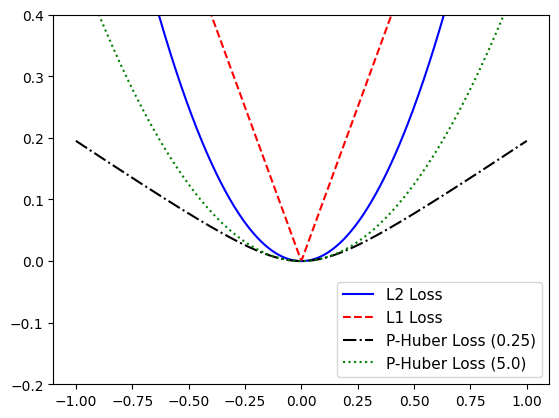

In [15]:
# Plotted on a graph to describe the shape of each function
funcs = [
  (l2, 'b-', 'L2 Loss'),
  (l1, 'r--', 'L1 Loss'),
  (phuber1, 'k-.', 'P-Huber Loss (0.25)'),
  (phuber2, 'g:', 'P-Huber Loss (5.0)')
]

for func, line_type, func_name in funcs:
  plt.plot(
    x_vals,
    func(y_true=target, y_pred=x_vals),
    line_type,
    label=func_name
  )
plt.ylim(-0.2, 0.4)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()

Prediction of a categorical dependent variable

In [18]:
x_vals = tf.linspace(-3., 5., 500)
target = tf.fill([500,], 1.)

In [19]:
def hinge(y_true, y_pred):
  return tf.maximum(0., 1. - tf.multiply(y_true, y_pred))

In [20]:
def xentropy(y_true, y_pred):
  return (-tf.multiply(y_true, tf.math.log(y_pred)) - tf.multiply((1. - y_true), tf.math.log(1. - y_pred)))

In [21]:
def sigmoid_xentropy(y_true, y_pred):
  return tf.nn.sigmoid_cross_entropy_with_logits(
    labels=y_true,
    logits=y_pred
  )

In [28]:
def weighted_xentropy(y_true, y_pred):
  weight = tf.constant(0.5)
  return tf.nn.weighted_cross_entropy_with_logits(
    labels=y_true,
    logits=y_pred,
    pos_weight=weight
  )

In [23]:
def softmax_xentropy(y_true, y_pred):
  return tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

unscaled_logits = tf.constant([[1., -3., 10.]])
target_distribution = tf.constant([[0.1, 0.02, 0.88]])
print(softmax_xentropy(y_true=target_distribution, y_pred=unscaled_logits))

tf.Tensor([1.1601256], shape=(1,), dtype=float32)


In [24]:
def sparse_xentropy(y_true, y_pred):
  return tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y_true,
    logits=y_pred,
  )

unscaled_logits = tf.constant([[1., -3., 10.]])
sparse_target_dist = tf.constant([2])
print(sparse_xentropy(y_true=sparse_target_dist, y_pred=unscaled_logits))

tf.Tensor([0.00012564], shape=(1,), dtype=float32)


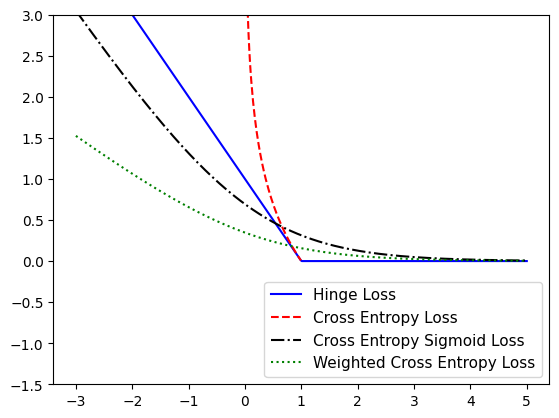

In [29]:
# Plotted on a graph to describe the shape of each function
funcs = [
  (hinge, 'b-', 'Hinge Loss'),
  (xentropy, 'r--', 'Cross Entropy Loss'),
  (sigmoid_xentropy, 'k-.', 'Cross Entropy Sigmoid Loss'),
  (weighted_xentropy, 'g:', 'Weighted Cross Entropy Loss')
]

for func, line_type, func_name in funcs:
  plt.plot(
    x_vals,
    func(y_true=target, y_pred=x_vals),
    line_type,
    label=func_name
  )
plt.ylim(-1.5, 3)
plt.legend(loc='lower right', prop={'size': 11})
plt.show()

## Summary

Each metric/ loss function has pros and cons. The choice depends on the problem being solved and the nature of the problem/ data itself.

Because each metric will behanve differently and, depending on the problem, some loss minimization strategies will be better than others. So experiment!

Below is a table summarising the functions covered

| Loss Function | Use | Benefit | Disadvantages |
| ------------- | --- | ------- | ------------- |
| L2 | Regression | More stable | Less robust i.e more prone to outliers |
| L1 | Regression | More robust | Less stable i.e might still fluctuate even when close to target|
| Pseudo-Huber | Regression | More robust and stable | One more parameter to optimise |
| Hinge | Classification | Creates a max margin used for SVM | Unbounded loss, affected by outliers |
| Cross-entropy | Classification | More stable | Unbounded loss, less robust |

Metrics to consider:

* R-squared
* Root mean squared error
* Confusion matrix
* Recall
* Precision
* F-score

---

# Implementing Backpropogation

Backpropogation is how model variables are updated. Errors are backpropogated through the network in a way that __minimizes the loss function__.

An __optimisation function__ is used to compute the changes to be applied for each weight within the model each time data is parsed in and a prediction is obtained. Tensorflow will go through and figure out the backpropogation terms for all computations in the graph and modify variables accordingly.

* Example 1: Regression problem with a single weight and bias term with L2 norm loss
* Example 2: Binary classification model. Linear optimised model with sigmoid cross entropy loss

## Example 1: Regression model

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

np.random.seed(0)
tf.random.set_seed(1)

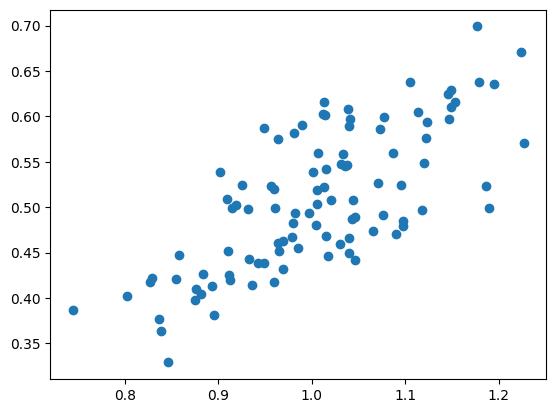

In [3]:
# Define the data and targets
x_vals = np.random.normal(1, 0.1, 100).astype(np.float32)
y_vals = (x_vals * (np.random.normal(1, 0.05, 100) - 0.5)).astype(np.float32)
plt.scatter(x_vals, y_vals)
plt.show()

In [4]:
def my_output(X, weights, biases):
  '''model - bX + a'''
  return tf.add(tf.multiply(X, weights), biases)

def loss_func(y_true, y_pred):
  '''L2 loss'''
  return tf.reduce_mean(tf.square(y_pred - y_true))

Optimisation algorithms require a _learning rate_ to indicate how far in a direction each step takes to change the variables in the model.

This is usually a hyperparameter to be optimised

In [17]:
my_opt = tf.optimizers.SGD(learning_rate=0.02)

In [ ]:
# Initialise starting values
weights = tf.Variable(tf.random.normal(shape=[1]))
biases = tf.Variable(tf.random.normal(shape=[1]))
history = []

In [12]:
# Training loop
for i in range(100):
  rand_index = np.random.choice(100)
  rand_x = [x_vals[rand_index]]
  rand_y = [y_vals[rand_index]]

  # gradienttape here records the set of variables (tf.Variable) that are used for automatic
  # differentiation
  with tf.GradientTape() as tape:
    predictions = my_output(rand_x, weights, biases)
    loss = loss_func(rand_y, predictions)
  history.append(loss.numpy())
  gradients = tape.gradient(loss, [weights, biases])
  my_opt.apply_gradients(zip(gradients, [weights, biases]))
  if (1 + i) % 25 == 0:
    print(f"Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}")
    print(f"Loss = {loss.numpy()}")

Step # 25 Weights: [-0.57249576] Biases: [0.916295]
Loss = 0.0915171429514885
Step # 50 Weights: [-0.50485003] Biases: [0.97861886]
Loss = 0.00013714825036004186
Step # 75 Weights: [-0.46517488] Biases: [1.0034196]
Loss = 0.07202576845884323
Step # 100 Weights: [-0.47813603] Biases: [0.97745514]
Loss = 0.002147938823327422


`tf.GradientTape()` tracks the computation and calculate the gradient with respect to the observed variables. All variables (`tf.Variable`) within the scope is monitored. Once monitoring is completed, gradient is computed using the `tape.gradient(target, source)` to get the tensor of gradients to be applied to the minimisation process.

Constants can also be monitered using `tape.watch(constant)`

_Good description of what gradient tape does: https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape_

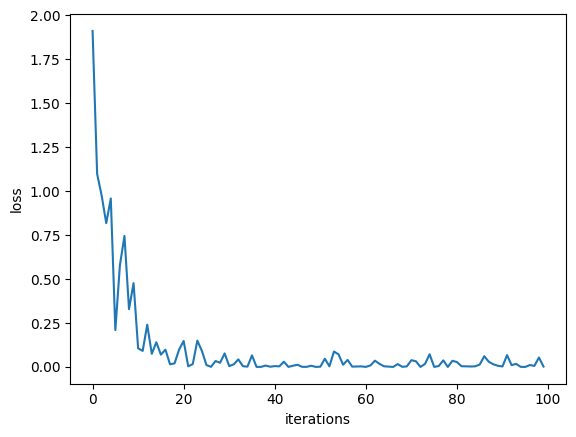

In [13]:
plt.plot(history)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## Example 2: Classification model

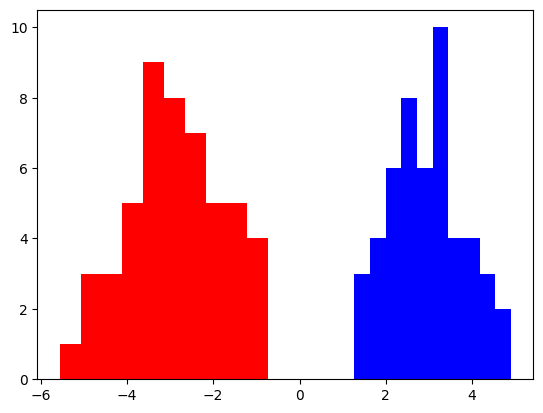

In [24]:
# Generate data
np.random.seed(0)
x_vals = np.concatenate((
  np.random.normal(-3, 1, 50),
  np.random.normal(3, 1, 50)
)).astype(np.float32)
y_vals = np.concatenate((np.repeat(0., 50), np.repeat(1., 50))).astype(np.float32)

plt.hist(x_vals[y_vals==1], color='b')
plt.hist(x_vals[y_vals==0], color='r')
plt.show()

In [25]:
my_opt = tf.optimizers.SGD(learning_rate=0.02)

In [26]:
def loss_func(y_true, y_pred):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=y_true,
    logits=y_pred
  ))

In [27]:
weights = tf.Variable(tf.random.normal(shape=[1]))
biases = tf.Variable(tf.random.normal(shape=[1]))
history = []

In [28]:
# Training loop
for i in range(100):    
  rand_index = np.random.choice(100) 
  rand_x = [x_vals[rand_index]] 
  rand_y = [y_vals[rand_index]]
  with tf.GradientTape() as tape:
    predictions = my_output(rand_x, weights, biases)
    loss = loss_func(rand_y, predictions)
  history.append(loss.numpy())
  gradients = tape.gradient(loss, [weights, biases])
  my_opt.apply_gradients(zip(gradients, [weights, biases]))
  if (i + 1) % 25 == 0: 
    print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
    print(f'Loss = {loss.numpy()}')

Step # 25 Weights: [1.0550721] Biases: [-0.40566534]
Loss = 0.2634499967098236
Step # 50 Weights: [1.1272607] Biases: [-0.40046495]
Loss = 0.11349382251501083
Step # 75 Weights: [1.1731158] Biases: [-0.40449852]
Loss = 0.013097080402076244
Step # 100 Weights: [1.2255731] Biases: [-0.39982006]
Loss = 0.09836643934249878


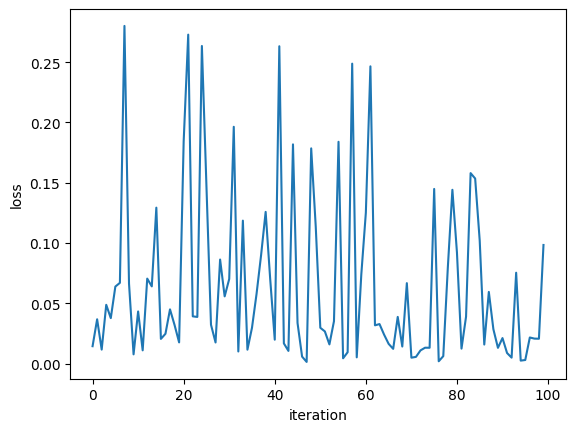

In [29]:
plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

There are some issues with the learning process for the classification model. But the learning process is stochstic in nature because the data is selected randomly and used individually to adjust the models position, and therefore, some times loss can increase

## A note on learning rates

* __Smaller learning rate__: Converges slowly, but produces more accurate results. Apply if solution is unstable. Too low and it might cause the vanishing gradient problem
* __Larger learning rate__: Less accurate, but fadster. Prevents solutions from stagnating and deads from going dead. Might lead to explosive gradient problem.

Learning rates can also get stuck on a __saddle point__ where the gradient is considered at a minimum, but it is not the global minimum, ie. the output might get better with better optimisations.

* __**Momentum__ -- Adds a fraction of the prior steps gradeitn value before you a access the 

## Types of optimisation algorithms

Most of these techniques refer to how large a step is taken when training the model.

1. __Adagrad__ - vary the step taken, larger steps for smaller moving variables and shorter steps for faster changing variables
2. __Adadelta__ - an improvement to the Adagrad algorithm, limits the number of steps used.

And there are many others that are used in different situations

---

# Working with Batch and Stochastic Training

Operating on a single piece of data for each step causes and erratic learning process. Have to choose the right subset of data to ensure __good convergence__.

Two improvements that can be made are:

1. _Using batched data_ - aggregating and averaging the loss for gradient calculations will prevent erratic changes and stop outliers from influencing the change as much
2. _Stochastic training_ - instead of computing the exact gradient which might be computationally expensive, using randomly selected data points will give a good enough approximation while still allowing for much larger overall data loads 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

np.random.seed(0)
tf.random.set_seed(1)

In [31]:
# declare the number of entries to be used in each set
BATCH_SIZE = 20

In [43]:
# Training loop with Batch Stochastic Optimisation
np.random.seed(0)
tf.random.set_seed(1)

x_vals = np.random.normal(1, 0.1, 100).astype(np.float32)
y_vals = (x_vals * (np.random.normal(1, 0.05, 100) - 0.5)).astype(np.float32)

def loss_func(y_pred, y_true):
  return tf.reduce_mean(tf.square(y_pred - y_true))

my_opt = tf.optimizers.SGD(learning_rate=0.02)

weights = tf.Variable(tf.random.normal(shape=[1]))
biases = tf.Variable(tf.random.normal(shape=[1]))
history_batch = []

for i in range(50):
  rand_index = np.random.choice(100, size=BATCH_SIZE)
  rand_x = [x_vals[rand_index]]
  rand_y = [y_vals[rand_index]]

  with tf.GradientTape() as tape:
    predictions = my_output(rand_x, weights, biases)
    loss = loss_func(predictions, rand_y)
  history_batch.append(loss.numpy())

  gradients = tape.gradient(loss, [weights, biases])
  my_opt.apply_gradients(zip(gradients, [weights, biases]))

  if (i+1) % 25 == 0:
    print(f"Step #{i+1} Weights: {weights.numpy()} | Biases: {biases.numpy()}")
    print(f"Loss = {loss.numpy()}")

Step #25 Weights: [-0.5585293] | Biases: [0.92651534]
Loss = 0.03692679852247238
Step #50 Weights: [-0.4854001] | Biases: [0.9882368]
Loss = 0.016214296221733093


In [44]:
# Training Loop with Stochastic Optimisation
np.random.seed(0)
tf.random.set_seed(1)

my_opt = tf.optimizers.SGD(learning_rate=0.02)

weights = tf.Variable(tf.random.normal(shape=[1]))
biases = tf.Variable(tf.random.normal(shape=[1]))
history_stochastic = []

for i in range(50):
  rand_index = np.random.choice(100, size=1) # NOTE: the batch size here is one
  rand_x = [x_vals[rand_index]]
  rand_y = [y_vals[rand_index]]

  with tf.GradientTape() as tape:
    predictions = my_output(rand_x, weights, biases)
    loss = loss_func(predictions, rand_y)
  history_stochastic.append(loss.numpy())

  gradients = tape.gradient(loss, [weights, biases])
  my_opt.apply_gradients(zip(gradients, [weights, biases]))

  if (i+1) % 25 == 0:
    print(f"Step #{i+1} Weights: {weights.numpy()} | Biases: {biases.numpy()}")
    print(f"Loss = {loss.numpy()}")

Step #25 Weights: [-0.5800964] | Biases: [0.9121798]
Loss = 0.13842469453811646
Step #50 Weights: [-0.50502247] | Biases: [0.9813487]
Loss = 0.006441597361117601


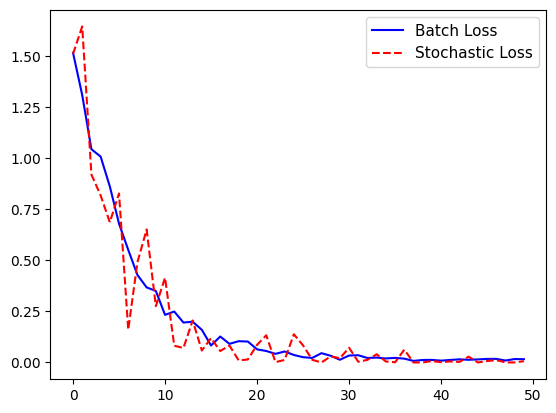

In [45]:
plt.plot(history_batch, 'b-', label='Batch Loss')
plt.plot(history_stochastic, 'r--', label='Stochastic Loss')
plt.legend(loc='upper right', prop={'size': 11})
plt.show()

## Summary

* Batch optimisation is smoother compared to the erratic nature of stochastic gradient descent
* Randomness is not always a bad thing (in the case of stochstic gradient descent) because it can help get out of local minimums
* Batch optmisation helps to find the minimum quicker - observe convergence happens earlier on graph

---

# Combining Everything Together

Classification model for the iris dataset. Binary classier to determine whether a flowers species is a Iris setosa based on their characteristics

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

In [15]:
# Load the data
iris = tfds.load('iris', split='train[:90%]', as_supervised=True)
iris_test = tfds.load('iris', split='train[90%:]', as_supervised=True)

In [16]:
# Define the batch size
BATCH_SIZE = 20
LEARNING_RATE = 0.02

# Define the train/ test data generator
def iris2d(features, label):
  '''
  1. select the last 2 columns from the dataset only
  2. change the value to 1 if the label is 0, and 0 otherwise (iris setosa is labelled 0 in
  the original dataset)
  '''
  return features[2:], tf.cast((label == 0), dtype=tf.float32)

train_generator = (
  iris
  .map(iris2d)
  .shuffle(buffer_size=100)
  .batch(BATCH_SIZE)
)
test_generator = iris_test.map(iris2d).batch(1)

In [17]:
def linear_model(X, A, b):
  '''Define the linear model - AX + b'''
  my_output = tf.add(tf.matmul(X, A), b)
  return tf.squeeze(my_output)

def xentropy(y_true, y_pred):
  '''Define the loss function - cross entropy'''
  return tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
  )

In [23]:
# Define the optimiser used - stochastic gradient descent
my_opt = tf.optimizers.SGD(learning_rate=LEARNING_RATE)

In [24]:
tf.random.set_seed(1)
np.random.seed(0)

# Training loop
A = tf.Variable(tf.random.normal(shape=[2,1]))
b = tf.Variable(tf.random.normal(shape=[1]))
history = []

for i in range(300):
  iteration_loss = []
  for features, label in train_generator:
    with tf.GradientTape() as tape:
      predictions = linear_model(features, A, b)
      loss = xentropy(label, predictions)
    iteration_loss.append(loss.numpy())
    gradient = tape.gradient(loss, [A, b])
    my_opt.apply_gradients(zip(gradient, [A, b]))
  history.append(np.mean(iteration_loss))
  
  if (i + 1) % 30 == 0:
    print(f"Step #{i+1} - Weights: {A.numpy().T} | Biases: {b.numpy()}")
    print(f"Loss = {loss.numpy()}")

Step #30 - Weights: [[-1.1199195  1.2997141]] | Biases: [1.0114565]
Loss = 0.23616601526737213
Step #60 - Weights: [[-1.1812419  1.0795417]] | Biases: [1.5128171]
Loss = 0.2945791184902191
Step #90 - Weights: [[-1.2457781   0.89214206]] | Biases: [1.9323899]
Loss = 0.18952472507953644
Step #120 - Weights: [[-1.3018224  0.7338416]] | Biases: [2.289665]
Loss = 0.14403441548347473
Step #150 - Weights: [[-1.3535285  0.5968404]] | Biases: [2.5980968]
Loss = 0.14629824459552765
Step #180 - Weights: [[-1.4023321  0.4770317]] | Biases: [2.867249]
Loss = 0.14605756103992462
Step #210 - Weights: [[-1.4456      0.37134352]] | Biases: [3.1064441]
Loss = 0.14355437457561493
Step #240 - Weights: [[-1.4869854  0.2764391]] | Biases: [3.3206942]
Loss = 0.06432093679904938
Step #270 - Weights: [[-1.526032   0.1903936]] | Biases: [3.514217]
Loss = 0.08726504445075989
Step #300 - Weights: [[-1.5613251   0.11205959]] | Biases: [3.6912549]
Loss = 0.058139581233263016


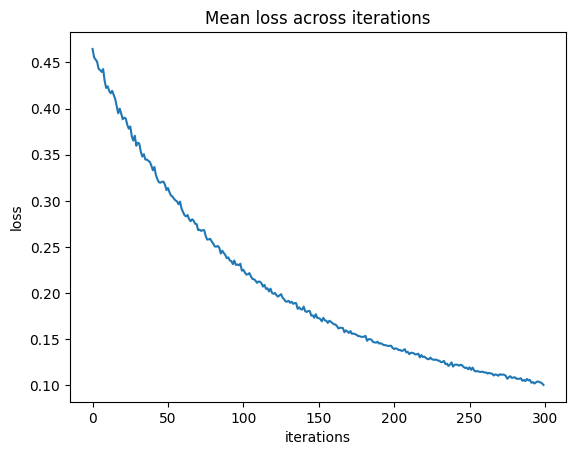

In [26]:
plt.plot(history)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Mean loss across iterations')
plt.show()

Performance on test set

In [28]:
predictions = []
labels = []
for features, label in test_generator:
  predictions.append(linear_model(features, A, b).numpy())
  labels.append(label.numpy()[0])

test_loss = xentropy(np.array(labels), np.array(predictions)).numpy()
print(f"Test cross entropy loss: {test_loss}")

Test cross entropy loss: 0.10229753702878952


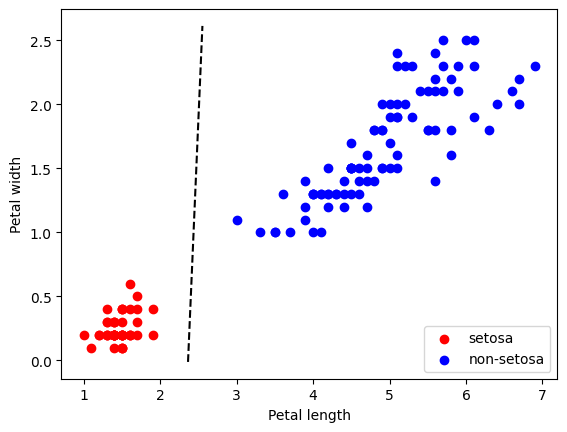

In [32]:
coefficients = np.ravel(A.numpy())
intercept = np.ravel(b.numpy())

# Plotting batch of examples from sampled data
for j, (features, label) in enumerate(train_generator):
  setosa_mask = label.numpy() == 1
  setosa = features.numpy()[setosa_mask]
  non_setosa = features.numpy()[~setosa_mask]
  plt.scatter(setosa[:,0], setosa[:,1], c='red', label='setosa')
  plt.scatter(non_setosa[:,0], non_setosa[:,1], c='blue', label='non-setosa')
  if j == 0:
    plt.legend(loc='lower right')

# Computing and plotting the decision function
a = - coefficients[0] / coefficients[1]
xx = np.linspace(plt.xlim()[0], plt.xlim()[1], num=10000)
yy = a * xx - intercept / coefficients[1]
on_the_plot = (yy > plt.ylim()[0]) & ( yy < plt.ylim()[1])
plt.plot(xx[on_the_plot], yy[on_the_plot], 'k--')

plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()

There are factors that might impact the performance of this model e.g new observations. Other techniques and recipes increase the generalisation of the model.

---